In [14]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


In [15]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files1 = glob('/content/drive/MyDrive/Colab Notebooks/1_ht_data/train/ants/*.jpg')
train_files2 = glob('/content/drive/MyDrive/Colab Notebooks/1_ht_data/train/bees/*.jpg')
train_files = train_files1 + train_files2
test_files1 = glob('/content/drive/MyDrive/Colab Notebooks/1_ht_data/val/ants/*.jpg')
test_files2 = glob('/content/drive/MyDrive/Colab Notebooks/1_ht_data/val/bees/*.jpg')
test_files = test_files1 + test_files2

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('ant') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

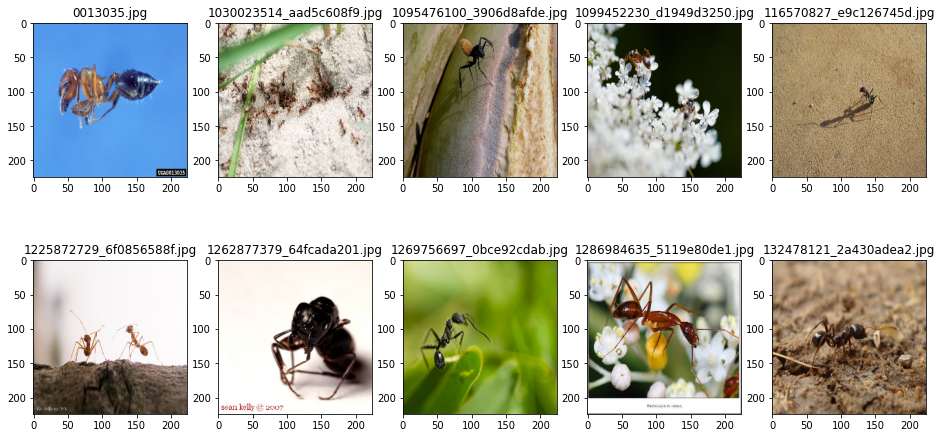

In [16]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [17]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [18]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='bees_vs_ants')

In [19]:
model.summary()

Model: "bees_vs_ants"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [20]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [21]:
val_samples = 50  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=5,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/10
5/5 [==============================] - 93s 18s/step - loss: 34.4682 - accuracy: 0.7284 - val_loss: 0.0433 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 85s 18s/step - loss: 28.7470 - accuracy: 0.9979 - val_loss: 0.0486 - val_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 85s 18s/step - loss: 38.4402 - accuracy: 0.9966 - val_loss: 0.0519 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 85s 18s/step - loss: 0.0525 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 85s 18s/step - loss: 8.8734 - accuracy: 0.9945 - val_loss: 0.0559 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 85s 18s/step - loss: 0.0563 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 85s 18s/step - loss: 0.0575 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 1.0000
Epoch 8/10
5/5 [========

In [22]:
model.save('ants-bees-vgg16.hdf5')

In [23]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

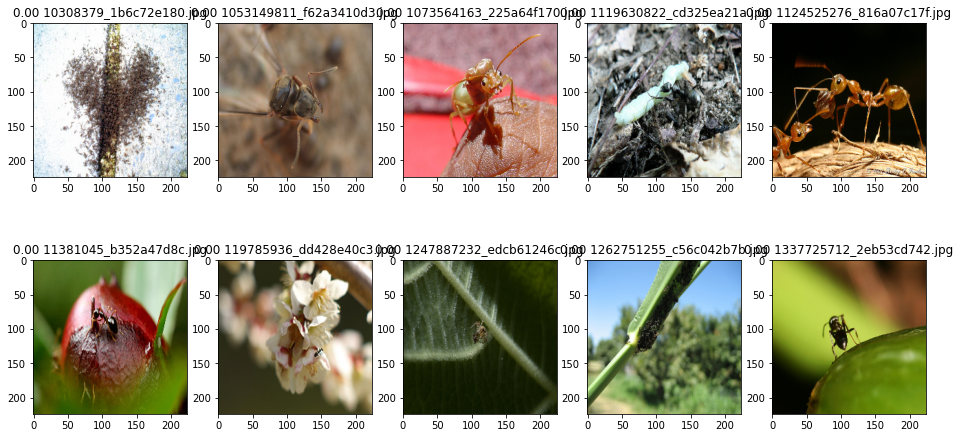

In [24]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

Добавим BatchNormalization

In [25]:
# import BatchNormalization
from keras.layers.normalization import BatchNormalization

In [26]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model_BN = tf.keras.Model(inputs=base_model.input, outputs=x, name='bees_vs_ants_2')

In [27]:
model_BN.summary()

Model: "bees_vs_ants_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [28]:
model_BN.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [29]:
val_samples = 50  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model_BN.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 152s 15s/step - loss: 0.3901 - accuracy: 0.8393 - val_loss: 0.0503 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 150s 15s/step - loss: 0.0509 - accuracy: 1.0000 - val_loss: 0.0552 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 150s 15s/step - loss: 0.0557 - accuracy: 1.0000 - val_loss: 0.0572 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 150s 15s/step - loss: 0.0573 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 151s 15s/step - loss: 0.0572 - accuracy: 1.0000 - val_loss: 0.0566 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 150s 15s/step - loss: 0.0563 - accuracy: 1.0000 - val_loss: 0.0555 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 150s 15s/step - loss: 0.0552 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 1.0000
Epoch 

In [30]:
test_pred = model_BN.predict(
    predict_generator(test_files), steps=len(test_files))

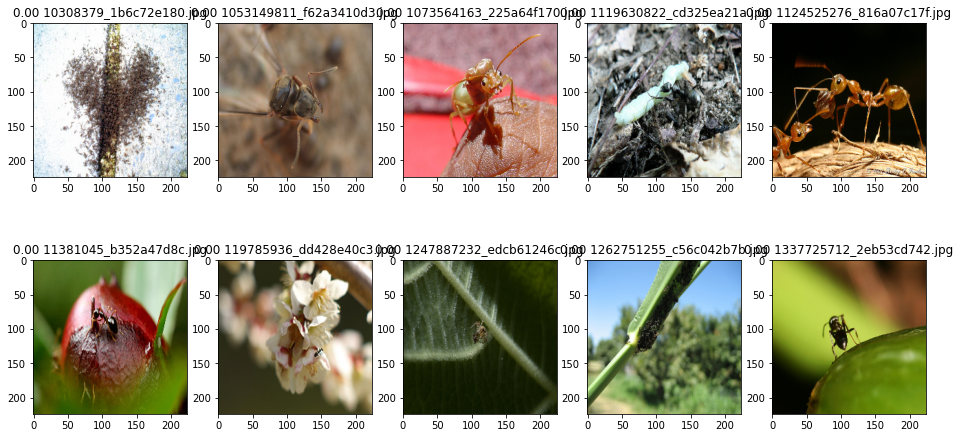

In [31]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

ResNet50

In [32]:
from tensorflow.keras.applications import ResNet50

In [33]:
base_RN_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [34]:
# фиксируем все веса предобученной сети
for layer in base_RN_model.layers:
    layer.trainable = False

x = base_RN_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

RN_model = tf.keras.Model(inputs=base_RN_model.input, outputs=x, name='bees_vs_ants')

In [35]:
RN_model.summary()

Model: "bees_vs_ants"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [36]:
RN_model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [37]:
val_samples = 50
  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
RN_model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 56s 5s/step - loss: 0.2238 - accuracy: 0.8614 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 52s 5s/step - loss: 0.0553 - accuracy: 0.9966 - val_loss: 0.0212 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 52s 5s/step - loss: 0.0539 - accuracy: 0.9960 - val_loss: 0.0210 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 52s 5s/step - loss: 0.0422 - accuracy: 0.9950 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 52s 5s/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 52s 5s/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 52s 5s/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 8/10
10/10 [==

In [38]:
RN_model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 52s 5s/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 52s 5s/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 52s 5s/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 52s 5s/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 52s 5s/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 52s 5s/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 52s 5s/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 8/10
10/10 [==

In [39]:
test_pred = RN_model.predict(
    predict_generator(test_files), steps=len(test_files))

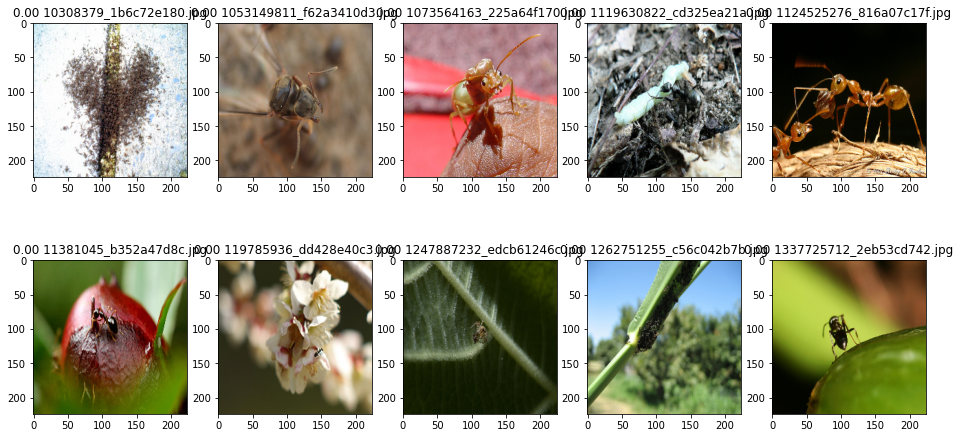

In [40]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)